<a href="https://colab.research.google.com/github/Kinexity/light-ML/blob/main/Tlight_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.colab import drive
from scipy.stats import gaussian_kde
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing dataset for nrows events:
dataset_main=pd.read_csv("/content/drive/My Drive/ML_light/source_24Na.csv.gzip", compression="gzip")

In [ ]:
def bucket_data(dataframe, number):
    ninth_column = dataframe.iloc[:, 8]

    # Finding the minimum and maximum values of the ninth column
    min_val = ninth_column.min()
    max_val = ninth_column.max()

    # Calculating the width of each bucket
    bucket_width = (max_val - min_val) / number

    # Creating the buckets
    buckets = [min_val + i * bucket_width for i in range(number)] + [max_val]

    # Bucketing the data based on the ninth column
    dataframe['Bucket'] = pd.cut(ninth_column, bins=buckets, labels=False)

    buckets_list = [group for _, group in dataframe.groupby('Bucket')]

    buckets_dict = {np.average(group[" sum"].to_numpy()):group for group in buckets_list}

    buckets_list = list(buckets_dict.values())

    # Finding the index of the dataframe with the most elements
    index_of_max_elements = max(range(len(buckets_list)), key=lambda i: len(buckets_list[i]))

    buckets_list_subset = buckets_list[int(index_of_max_elements*0.1):index_of_max_elements]

    min_elements = min([len(df) for df in buckets_list_subset])

    buckets_list = [(df if len(df) <= min_elements else df.sample(min_elements + int(min_elements * np.log(len(df)/min_elements)))) for df in buckets_list]

    return pd.concat(buckets_list)

In [ ]:
#filter the dataset to get more even distribution of sums

dataset_full = dataset_main.copy().sample(1000000)
#dataset = dataset_full
dataset = bucket_data(dataset_main.copy(), 1000).sample(1000000)
print(dataset_main.shape[0])
print(dataset.shape[0])

10580761
1000000


In [ ]:
#Independent variables:
#X=dataset.iloc[:,0:6].values #only 6 PMTs summed, for example. We could also take N PMTS but shuffled randomly for each event, not always the first N ones
X=dataset.iloc[:,3:5].values #all PMTs summed
#Dependent variable:
Y=dataset.iloc[:,8].values
Y_full=dataset_full.iloc[:,8].values

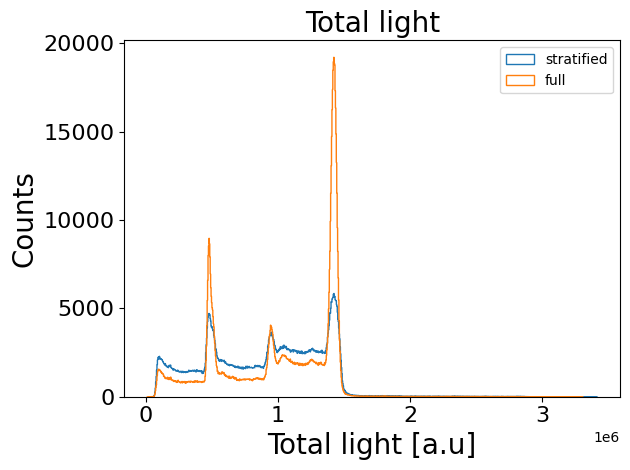

In [ ]:
fig, ax = plt.subplots()
nbins = 1000
n, bins, _ = plt.hist(Y, nbins, histtype='step', label = "stratified")#, density = True)
plt.hist(Y_full, nbins, histtype='step', label = "full")#, density = True)
ax.set_title("Total light", fontsize = 20.0)
ax.set_xlabel("Total light [a.u]",fontsize = 20.0)
ax.set_ylabel("Counts", fontsize = 20.0)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Split train and test sets
from sklearn.model_selection import train_test_split
#test_size: always between 0.2 and 0.3 (20-30% to the test set)
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2, shuffle=True, random_state=0)
X_train, X_test, Y_train, Y_test = X_test, X_train, Y_test, Y_train
val_data = (X_test, Y_test)

In [ ]:
#We apply feature scaling
from sklearn.preprocessing import RobustScaler
sc_X=RobustScaler()
X_train=sc_X.fit_transform(X_train)
X_test=sc_X.transform(X_test)

In [ ]:
#Random forest regression
#Average of the different decision tree predictions
#Non-linear model

from sklearn.ensemble import RandomForestRegressor
#n_estimators: number of trees
regressor=RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(X_train,Y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [ ]:
Y_pred=regressor.predict(X_test)

0.062230693253341456


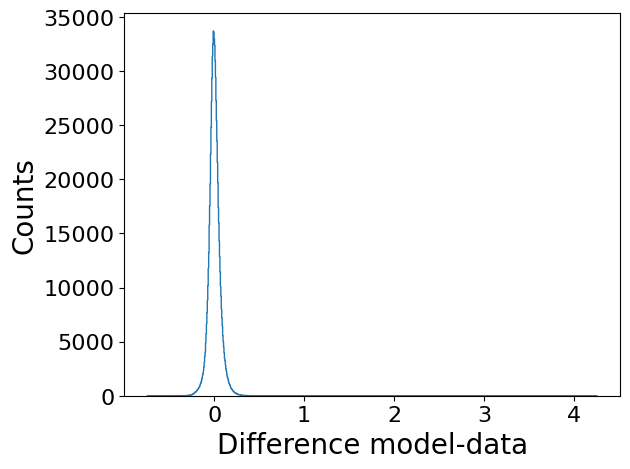

In [ ]:
#Evaluation of the performance by calculating diferences between real data and predictions (one could fit the peak with a gaussian and calculate the sigma)
fig, ax = plt.subplots()
nbins = 1000
print(np.std((Y_pred-Y_test)/Y_test))
n, bins, _ = plt.hist((Y_pred-Y_test)/Y_test, nbins, histtype='step')
ax.set_xlabel("Difference model-data",fontsize = 20.0)
ax.set_ylabel("Counts", fontsize = 20.0)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

plt.tight_layout()
plt.show()

800000
800000


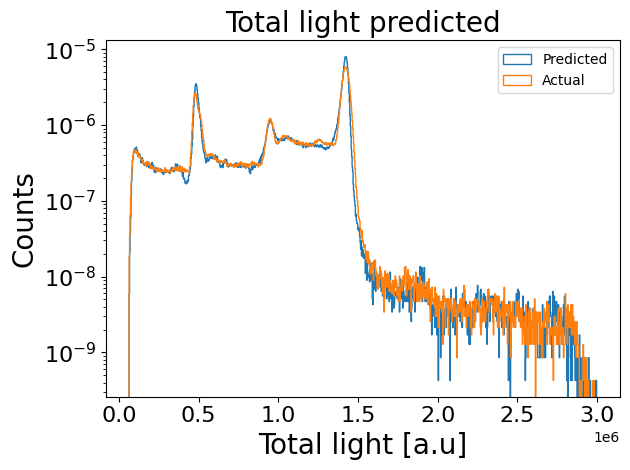

In [ ]:
#Plot predicted summed spectrum for test set
fig, ax = plt.subplots()
nbins = 1000
n, bins, _ = plt.hist(Y_pred, nbins, histtype='step', label = "Predicted", density=True)
print(Y_pred.size)
plt.hist(Y_test, bins=bins, histtype='step', label = "Actual", density=True)
print(Y_test.size)
#plt.hist(Y_test, bins=bins, histtype='step', label = "Actual", density=True)
#print(X_test.)
ax.set_title("Total light predicted", fontsize = 20.0)
ax.set_xlabel("Total light [a.u]",fontsize = 20.0)
ax.set_ylabel("Counts", fontsize = 20.0)
ax.set_yscale("log")
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

plt.legend()
plt.tight_layout()
plt.show()